In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10, 4)

#import scikit-learn libraries
from sklearn.impute import SimpleImputer, KNNImputer

In [2]:
df = pd.read_excel("mobilesales.xlsx", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2001-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   198 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


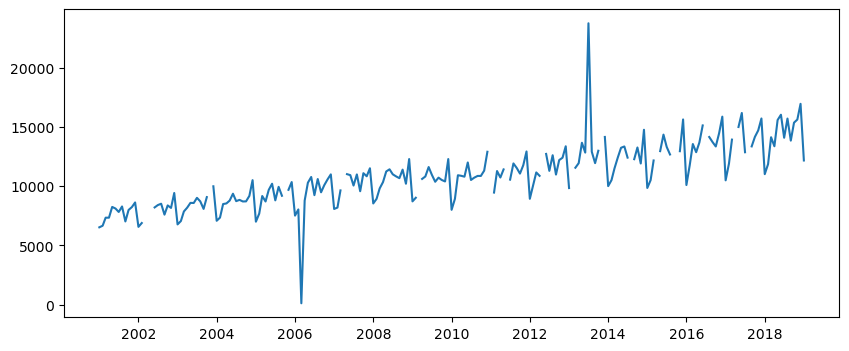

In [3]:
plt.plot(df["Sales"])
plt.show()

We can see that the data starts form "2001-01-01" to "2019-01-01"

We can see there are 19 missing values in the data. We need to impute the Data for the missing values

We can use the following techniques:
- mean/Median Imputation
- KNN Imputation
- fillNa function
- linear Imputation

# Data Imputation

## Mean/Median Imputation

In [4]:
# Plot Both graphs

def plotImputatedGraphs(before, after):
    plt.plot(after["Sales"], label="Imputed")
    plt.plot(before["Sales"], label="Original")
    plt.axhline(y=before["Sales"].mean(), linestyle=":", color="green")
    plt.legend()
    plt.show()

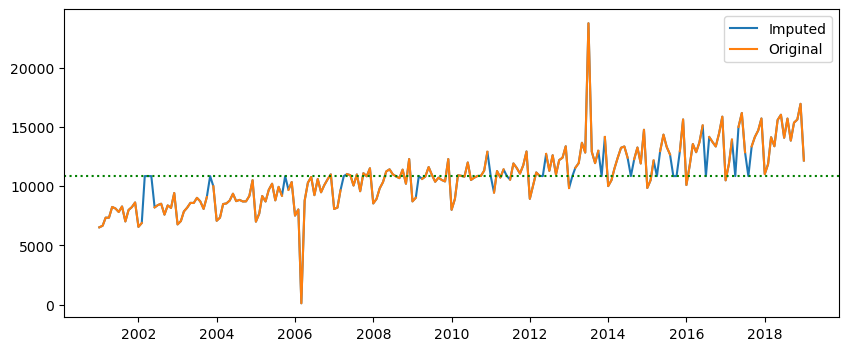

In [5]:
# Mean/Median Imputation
df_mean = df.copy()
df_mean = df_mean.fillna(value=df_mean["Sales"].mean())
plotImputatedGraphs(before=df, after=df_mean)

Not the best way to impute the data. 

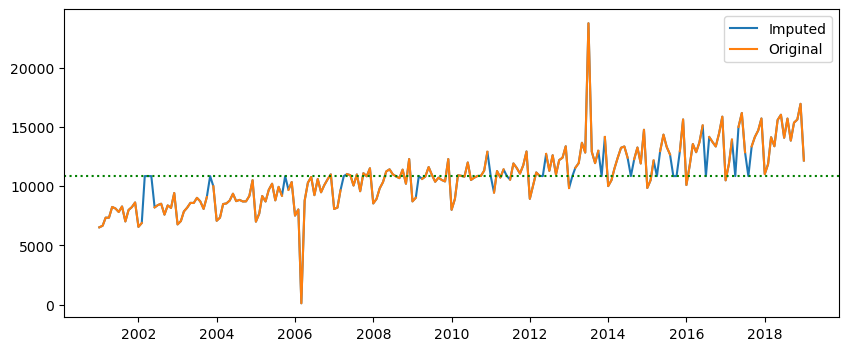

In [6]:
# same as Mean imputation but using Scikit learn

df_SI = df.copy()
simpImp = SimpleImputer(strategy="mean")
df_SI = pd.DataFrame(simpImp.fit_transform(df_SI), columns=simpImp.get_feature_names_out(), index=df_SI.index)
plotImputatedGraphs(before=df, after=df_SI)

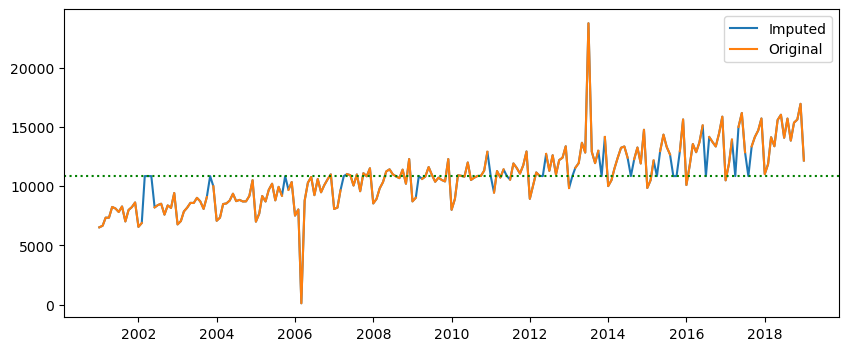

In [7]:
# KNN Imputation
knnImp = KNNImputer(n_neighbors=5)
df_KNN = pd.DataFrame(knnImp.fit_transform(df), columns=knnImp.get_feature_names_out(), index=df.index)
plotImputatedGraphs(before=df, after=df_KNN)

The filling looks exactly same as mean imputation

In [8]:
# forward Fill and Back Fill

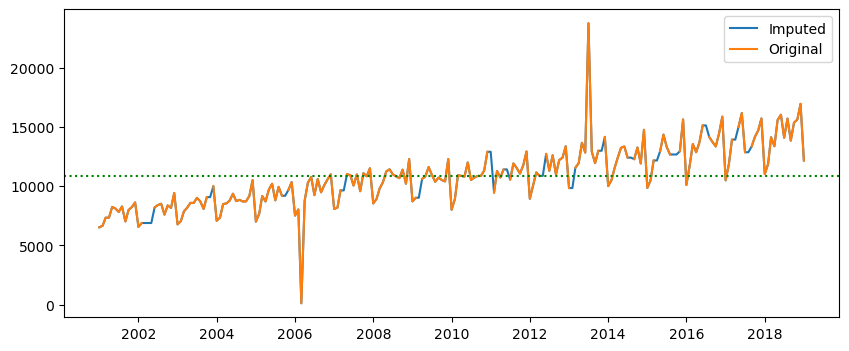

In [9]:
df_ff = df.copy()
df_ff["Sales"] = df["Sales"].fillna(method="ffill")
plotImputatedGraphs(before=df, after=df_ff)

Forward and backwords fill are soo much better than the mean/Median/KNN imputation

In [10]:
# linear imputation

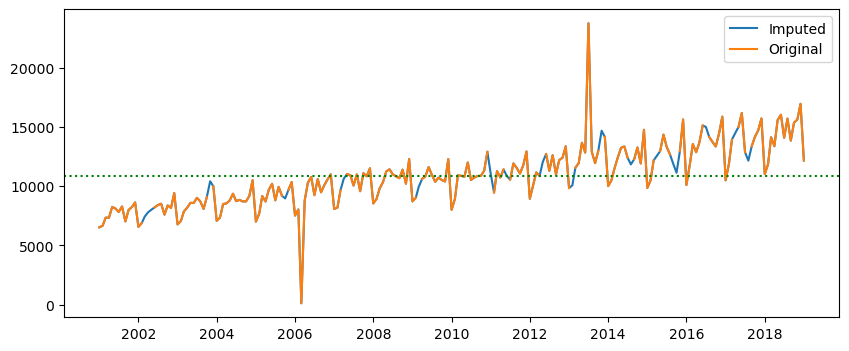

In [11]:
df_linInt = df.copy()
df_linInt["Sales"] = df["Sales"].interpolate(method="quadratic")
plotImputatedGraphs(before=df, after=df_linInt)

This imputation method is a lot better than the other imputation methods.

In [12]:
df["Sales"] = df["Sales"].interpolate(method="quadratic")

# Anamolies in the Data

We can see there are 2 anamolies in the data. We don't want our data to give wrong precitions because of the anamolies in the data.

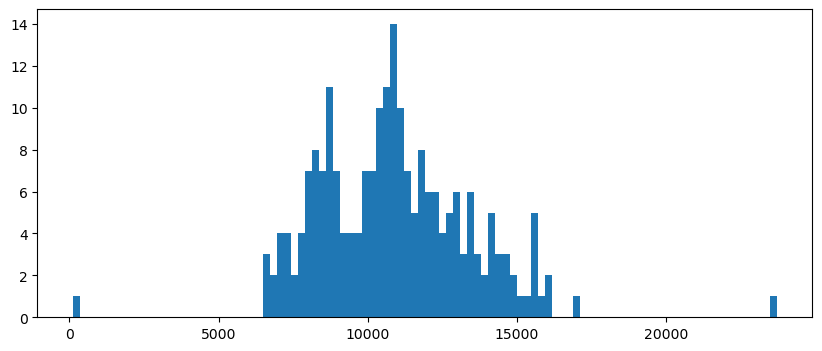

In [13]:
# cleaning anamolies in the data.

# We can clearly see 2 outliers in the Data
# We need to clip the data and later analize the reason for anamolies.
plt.hist(x=df["Sales"], bins=100)
plt.show()

In [14]:
df["Sales"].clip(lower=df["Sales"].quantile(0.01),
                 upper=df["Sales"].quantile(0.99), inplace=True)

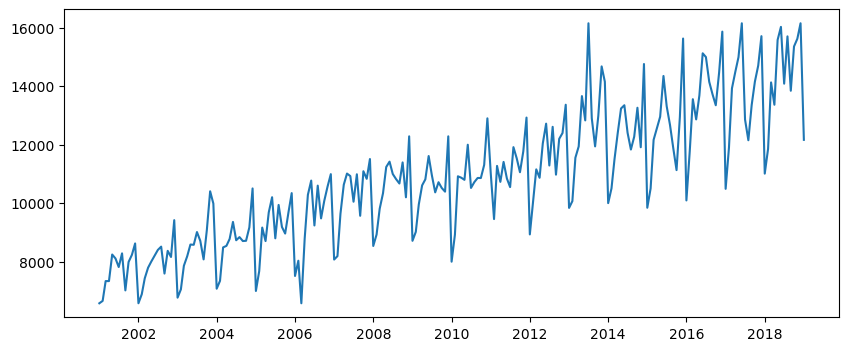

In [15]:
plt.plot(df["Sales"])
plt.show()

# ETS Decomposition

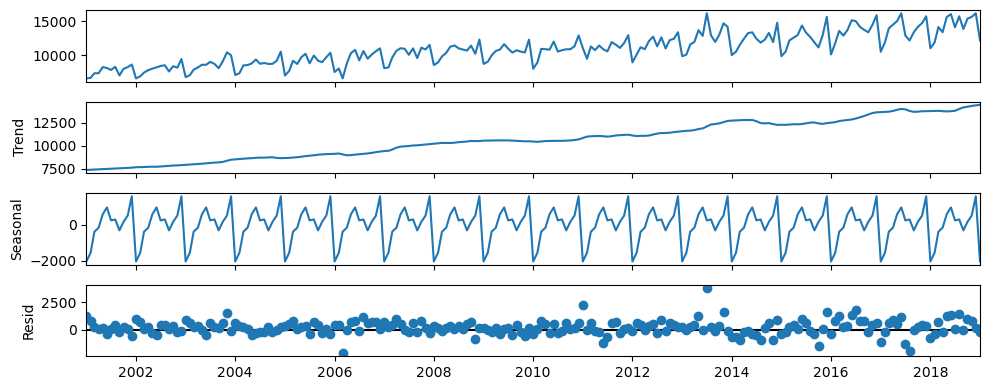

In [16]:
# one direct way to do the ETS decomposition is by using statsmodel

import statsmodels.api as sm_api

ets_model = sm_api.tsa.seasonal_decompose(df, model="additive", two_sided=False, extrapolate_trend=12)
ets_model.plot()
plt.show()

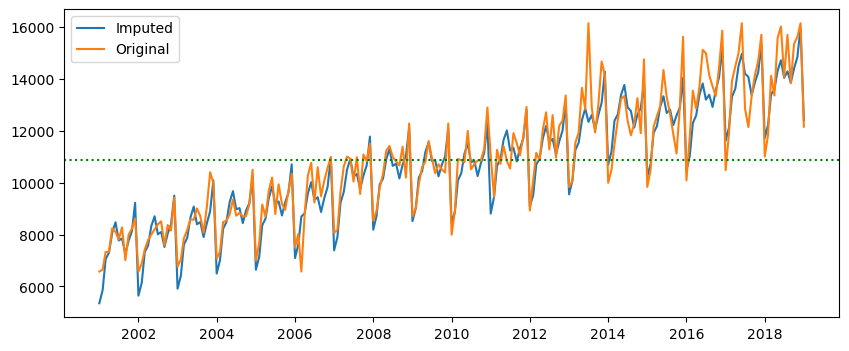

In [17]:
# trying to forecast the data using ETA

plotImputatedGraphs(before=df, after=pd.DataFrame(ets_model.trend + ets_model.seasonal, columns=["Sales"], index=df.index))

We can see that the Data is almost a perfect.

Limitations:
- Method is not for forecasting but for Understanding the Data.
- Sometimes the data has multiple trends and seasonalities, where this model failes
- No inbuild functions to forecast the data.

## Trend

We can get the Trend line of a data using the following methods.

We can use the window size as "Seasonality" value. Anything more than that will cause the Seasonality value to get added twice and lead to misleading values. Anything less is fine. As moving window size increases, the data starts to smoothen out, and the fluctuations in the data reduce

- Moving average

[]

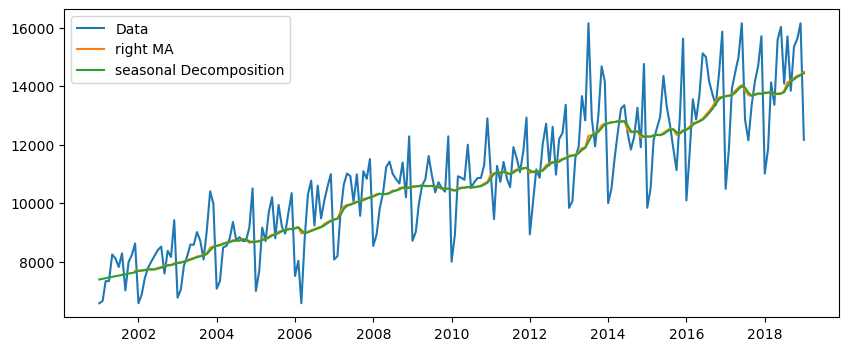

In [18]:
# moving average
df_decomp = df.copy()

df_decomp["trend"] = df.rolling(window=12, center=False).mean()
plt.plot(df, label="Data")
plt.plot(df_decomp["trend"], label="right MA")
plt.plot(ets_model.trend, label="seasonal Decomposition")
plt.legend()
plt.plot()


## We can see that the rigt moving average is lagging in change. ie, the changes are seen long after the actual dip in data. (right window)
## where as, the model from Seasonal Decomposition can be configured to center/right moving average by using two_sided parameter 

## Seasonality

[]

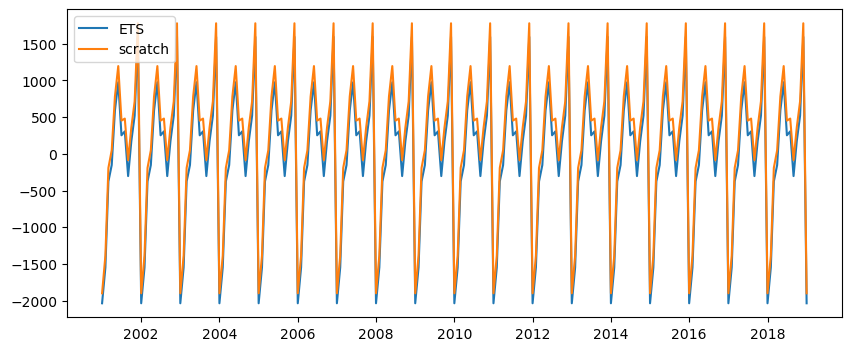

In [19]:
# seasonality can be calculated by averaging out data over seasonality Value
DeTrended = df_decomp["Sales"] - df_decomp["trend"]
df_decomp["Seasonality"] = DeTrended.groupby(by=df.index.month).transform("mean")

plt.plot(ets_model.seasonal, label="ETS")
plt.plot(df_decomp["Seasonality"], label="scratch")
plt.legend()
plt.plot()

## we ca see the data drom ETS model and out model are almost same.

# Forecast models

In [20]:
# Train Test Split

df.info()

print("\n")
# training Data has 205 datapoints.
# test Data has 12 Datapoints.

train = df.iloc[0:205]

print("\033[4mTRAIN TEST SPLIT:\033[0m")
print("size of train: ", train.shape)
test  = df.iloc[205:]
print("size of test: ", test.shape)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2001-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   217 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


TRAIN TEST SPLIT:
size of train:  (205, 1)
size of test:  (12, 1)


In [21]:
# evaluation functions

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
def eval_model(yVal, yPred):
    print("MAPE: ", np.round(mean_absolute_percentage_error(y_true=yVal, y_pred=yPred) * 100, 3))
    print("MAE:  ", np.round(mean_absolute_error(y_true=yVal, y_pred=yPred), 3))
    print("RMSE: ", np.round(root_mean_squared_error(y_true=yVal, y_pred=yPred), 3))

## Mean Forecast

In [22]:
# the Forecast value will be the mean of the complete TS
train["pred"] = train["Sales"].mean()
test["pred"] = train["Sales"].mean()

# # train Accuracy
print("TRAIN ACCURACY:")
eval_model(yVal=train["Sales"], yPred=train["pred"])

print()

# # test Accuracy
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=test["pred"])

TRAIN ACCURACY:
MAPE:  17.544
MAE:   1763.464
RMSE:  2195.113

TEST ACCURACY:
MAPE:  25.76
MAE:   3841.082
RMSE:  4094.343


Testing accuracy is <span style="color:Green">**25.76%**</span> MAPE <br>
The accuracy is pretty bad. Needs improvement.

## Naive Forecast

In [23]:
# the Forecast value will be the last data point.
test["pred"] = train["Sales"].iloc[-1]

# # test Accuracy
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=test["pred"])

TEST ACCURACY:
MAPE:  23.24
MAE:   3479.79
RMSE:  3757.483


Testing accuracy is <span style="color:Green">**23.24%**</span> MAPE <br>
The accuracy is pretty bad. Needs improvement.

## Seasonal Naive

In [24]:
# the Forecast value will be the last seasonal Value.

seasonality = 12
for i in range(test.shape[0]):
    trainIndex = i + (train.shape[0]) - seasonality
    test["pred"].iloc[i] = train.iloc[trainIndex]["Sales"]

# # test Accuracy
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=test["pred"])

TEST ACCURACY:
MAPE:  6.289
MAE:   920.97
RMSE:  1285.036


In [25]:
# method 2
test["pred"] = train.loc[test.index - pd.DateOffset(years=1), "Sales"].values

# # test Accuracy
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=test["pred"])

TEST ACCURACY:
MAPE:  6.289
MAE:   920.97
RMSE:  1285.036


Testing accuracy is <span style="color:Green">**6.289%**</span> MAPE <br>
Its good. But, might not work always<br>
We can get all past seasonalities, that would make the model even better